In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.datasets import cifar100
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt

In [2]:
# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


In [3]:
# Load CIFAR-100 data
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='coarse')
print("Original Shape:", X_train.shape, y_train.shape)

# Resize images to 140x140
X_train = np.array([cv2.resize(img, (140, 140)) for img in X_train])
X_test = np.array([cv2.resize(img, (140, 140)) for img in X_test])
print("Resized Shape:", X_train.shape, X_test.shape)

enc = OneHotEncoder()
y_train = enc.fit_transform(y_train).toarray().astype(int)
y_test = enc.transform(y_test).toarray().astype(int)
print("Encoded Labels Shape:", y_train.shape)

Original Shape: (50000, 32, 32, 3) (50000, 1)
Resized Shape: (50000, 140, 140, 3) (10000, 140, 140, 3)
Encoded Labels Shape: (50000, 20)


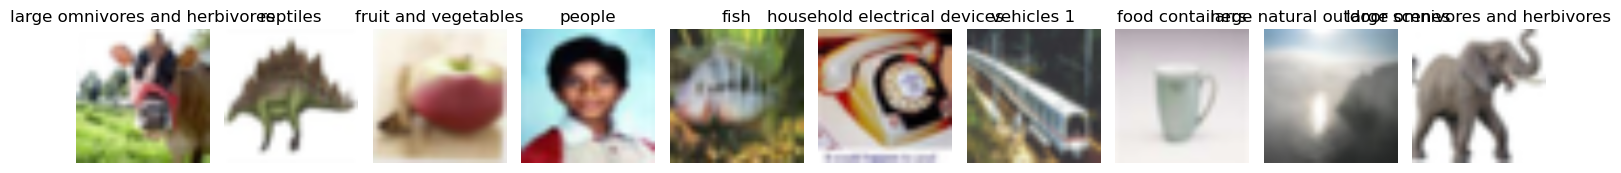

In [9]:
# Define a function to display sample images with their labels
def display_sample_images(X, y, class_names, num_samples=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(X[i].astype('uint8'))
        plt.title(class_names[np.argmax(y[i])])  # Convert one-hot to label index
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# CIFAR-100 coarse labels (20 classes)
coarse_label_names = [
    'aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 
    'household electrical devices', 'household furniture', 'insects', 'large carnivores',
    'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores',
    'medium-sized mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals',
    'trees', 'vehicles 1', 'vehicles 2'
]

# Display 10 sample images from the training set
display_sample_images(X_train, y_train, coarse_label_names)

In [4]:
# Data augmentation
def data_augmenter():
    data_augmentation = tf.keras.Sequential([
        tfl.RandomFlip('horizontal'),
        tfl.RandomRotation(0.2)
    ])
    return data_augmentation

In [6]:
data_augmentation = data_augmenter()

# Define AlexNet-inspired architecture
def arch(input_shape, data_augmentation):
    input_img = tf.keras.Input(shape=input_shape)
    layer = data_augmentation(input_img)
    layer = tfl.Conv2D(filters=96, kernel_size=11, strides=4)(layer)
    layer = tfl.ReLU()(layer)
    layer = tfl.MaxPool2D(pool_size=3, strides=2, padding='same')(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    layer = tfl.Conv2D(filters=256, kernel_size=5, strides=1, padding='same')(layer)
    layer = tfl.ReLU()(layer)
    layer = tfl.MaxPool2D(pool_size=3, strides=2, padding='same')(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    layer = tfl.Conv2D(filters=384, kernel_size=3, strides=1, padding='same')(layer)
    layer = tfl.ReLU()(layer)
    layer = tfl.Conv2D(filters=384, kernel_size=3, strides=1, padding='same')(layer)
    layer = tfl.ReLU()(layer)
    layer = tfl.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(layer)
    layer = tfl.ReLU()(layer)
    layer = tfl.MaxPool2D(pool_size=3, strides=2, padding='same')(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    layer = tfl.Flatten()(layer)
    layer = tfl.Dense(units=4096, activation='relu')(layer)
    layer = tfl.Dropout(0.2)(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    layer = tfl.Dense(units=4096, activation='relu')(layer)
    layer = tfl.Dropout(0.2)(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    layer = tfl.Dense(units=1000, activation='relu')(layer)
    layer = tfl.Dropout(0.2)(layer)
    layer = tfl.BatchNormalization()(layer, training=True)

    outputs = tfl.Dense(units=20, activation='softmax')(layer)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

# Build model
input_shape = (140, 140, 3)
conv_model = arch(input_shape, data_augmentation)
conv_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
conv_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 140, 140, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 140, 140, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 33, 33, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 33, 33, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 17, 17, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 17, 17, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 17, 17, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 17, 17, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 9, 9, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 9, 9, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 9, 9, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 9, 9, 384)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 9, 9, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 5, 5, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      26,218,4

 Total params: 50,903,228 (194.18 MB)

 Trainable params: 50,883,628 (194.11 MB)

 Non-trainable params: 19,600 (76.56 KB)

In [7]:
# Prepare datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).shuffle(len(X_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

# Train the model
history = conv_model.fit(train_dataset, epochs=3, validation_data=test_dataset, shuffle=True)

# Evaluate the model
test_loss, test_accuracy = conv_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 902s 1s/step - accuracy: 0.1554 - loss: 2.9659 - val_accuracy: 0.2217 - val_loss: 2.6520
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 842s 1s/step - accuracy: 0.2616 - loss: 2.4421 - val_accuracy: 0.3151 - val_loss: 2.2327
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 1150s 1s/step - accuracy: 0.3314 - loss: 2.1773 - val_accuracy: 0.3827 - val_loss: 1.9917
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 259ms/step - accuracy: 0.3802 - loss: 1.9889
Test Loss: 1.9917, Test Accuracy: 38.27%


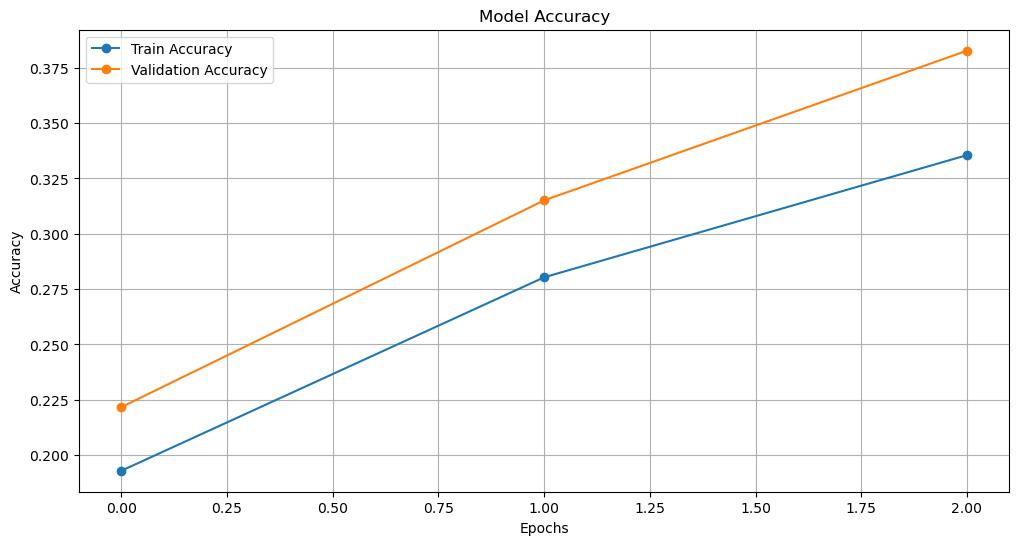

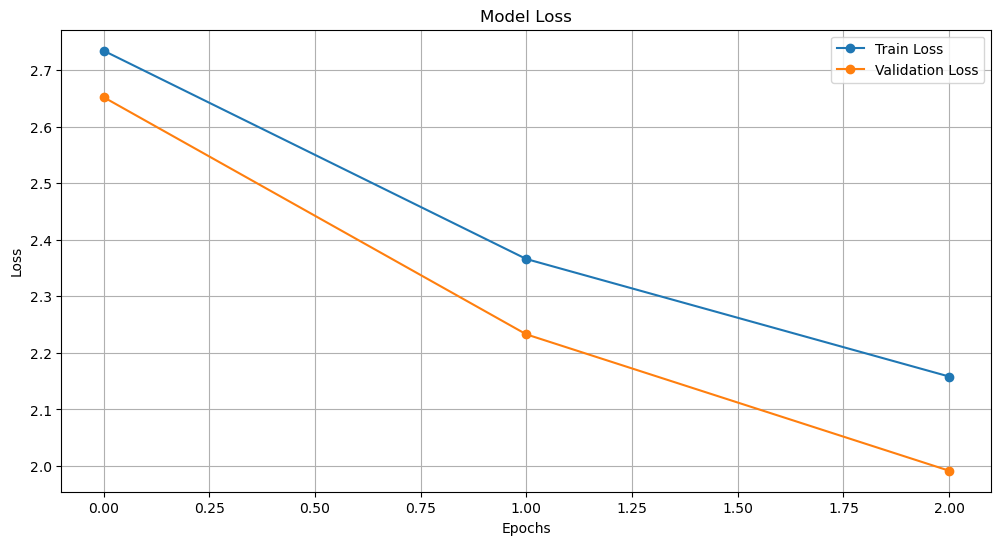

In [8]:
# Visualization
# Accuracy plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()